In [1]:
#import all required libraries
import nltk
import pandas as pd

In [2]:
nltk.download("movie_reviews")

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/prayashpathak/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


True

In [74]:
#import the dataset
rows = []
for fileid in nltk.corpus.movie_reviews.fileids():
    rows.append({"text": nltk.corpus.movie_reviews.raw(fileid)})
df = pd.DataFrame(rows)
print(len(df)) 
df.head()

2000


,text
0,"plot : two teen couples go to a church party ,..."
1,the happy bastard's quick movie review \ndamn ...
2,it is movies like these that make a jaded movi...
3,""" quest for camelot "" is warner bros . ' firs..."
4,synopsis : a mentally unstable man undergoing ...


In [75]:
#pre-processing: basic cleaning and removing stopwords(if needed)
# Load the regular expression library
import re
# Remove punctuation
df['text'] = \
df['text'].map(lambda x: re.sub('[,\.!?]', '', x))
#Convert the titles to lowercase
df['text'] = \
df['text'].map(lambda x: x.lower())
# Print out the first rows of papers
df['text'].head()

0    plot : two teen couples go to a church party  ...
1    the happy bastard's quick movie review \ndamn ...
2    it is movies like these that make a jaded movi...
3     " quest for camelot " is warner bros  ' first...
4    synopsis : a mentally unstable man undergoing ...
Name: text, dtype: object

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    max_df=.5, #ignores terms that appear in more than 50% of the documents
    min_df=10, #ignores terms that appear in fewer than 10 documents
    max_features=20000, #limits the vocabulary to the top 20,000 features
    ngram_range=(1, 2), #considers both unigrams and bigrams 
    norm=None, #no normalization is applied
    binary=True, #converts term frequency to binary
    use_idf=False,
    sublinear_tf=False
)
vectorizer = vectorizer.fit(df['text'])
tfidf = vectorizer.transform(df['text'])
vocab = vectorizer.get_feature_names_out()
print(len(vocab))

20000


In [80]:
#!pip install corextopic
from corextopic import corextopic as ct

In [79]:
#anchors = []
model = ct.Corex(n_hidden = 10, seed = 42) #arbitary topic numbers with no anchors
model = model.fit(
    tfidf,
    words = vocab
)

In [81]:
for i, topic_ngrams in enumerate(model.get_topics(n_words=10)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1]>0]
    print("Topic #{}: {}". format(i+1, ",".join(topic_ngrams)))

Topic #1: me,see,don,think,had,bad,my,because,didn,re
Topic #2: film is,world,of his,from the,it is,does,scenes,the most,that he,may
Topic #3: really,know,say,were,why,thing,it was,seen,did,ve
Topic #4: effects,special effects,special,alien,planet,computer,aliens,fi,sci,sci fi
Topic #5: scene,where,that the,many,by the,any,such,films,never,characters
Topic #6: perhaps,while,these,director,both,place,young,part,following,serve
Topic #7: life,role,performance,he is,love,relationship,father,in his,wife,mother
Topic #8: doesn,seems,few,the character,he has,seems to,work,makes,takes,bit
Topic #9: she,that she,of her,with her,herself,she is,to her,she has,and she,her to
Topic #10: carrey,murphy,jim carrey,eddie murphy,its predecessor,the killer,predecessor,thriller,believe it,killer


In [82]:
model.tc

57.92580209634289

In [83]:
# Let's choose the num of topics
def compute_total_correlation_values(tfidf, vocab, limit, start, step):
    """
    Compute total correlation for various number of topics using CorEx

    Parameters:
    ----------
    tfidf : TF-IDF transformed data
    vocab : Vocabulary corresponding to the TF-IDF data
    limit : Max num of topics
    start : Starting number of topics
    step : Step size for the number of topics

    Returns:
    -------
    model_list : List of CorEx topic models
    tc_values : Total correlation values corresponding to the CorEx model with respective number of topics
    """
    tc_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        model = ct.Corex(n_hidden=num_topics)
        model.fit(tfidf, words=vocab)
        model_list.append(model)
        tc_values.append(model.tc)

    return model_list, tc_values

In [84]:
model_list, tc_values = compute_total_correlation_values(tfidf, vocab, limit=11, start=1, step=1)

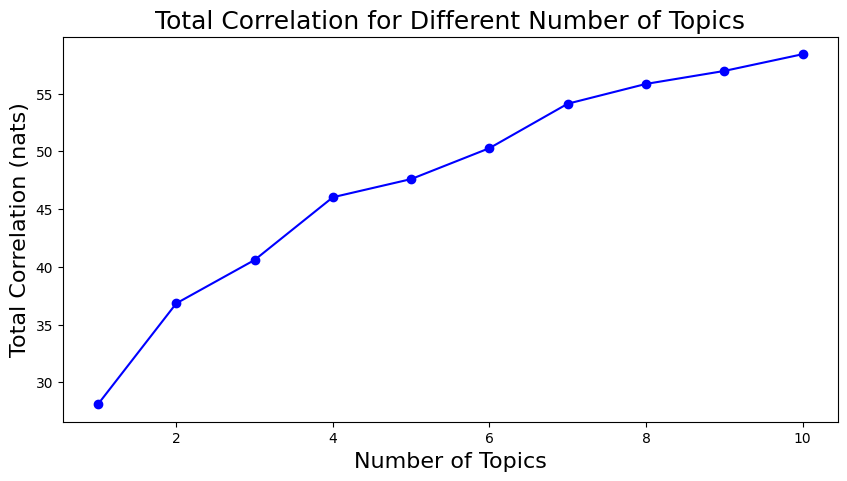

In [85]:
# Plotting the total correlation values
import matplotlib.pyplot as plt

limit=11; start=1; step=1;
x = range(start, limit, step)
plt.figure(figsize=(10, 5))
plt.plot(x, tc_values, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Topics', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.title('Total Correlation for Different Number of Topics', fontsize=18)
plt.show()

In [86]:
# Print the total correlation scores
for num_topics, tc in zip(range(start, limit, step), tc_values):
    print("Num Topics =", num_topics, "has Total Correlation of", round(tc, 4))

Num Topics = 1 has Total Correlation of 28.1044
Num Topics = 2 has Total Correlation of 36.836
Num Topics = 3 has Total Correlation of 40.5921
Num Topics = 4 has Total Correlation of 46.025
Num Topics = 5 has Total Correlation of 47.5978
Num Topics = 6 has Total Correlation of 50.275
Num Topics = 7 has Total Correlation of 54.1227
Num Topics = 8 has Total Correlation of 55.8375
Num Topics = 9 has Total Correlation of 56.9601
Num Topics = 10 has Total Correlation of 58.4089


In [87]:
# Anchors to direct the topics to specific keywords which represent different genres
anchors = [
    ["action", "adventure"],
    ["drama"],
    ["comedy", "funny"],
    ["horror", "suspense"],
    ["animated", "animation"],
    ["sci fi", "alien"],
    ["romance", "romantic"],
    ["fantasy"]
]
anchors = [
    [a for a in topic if a in vocab]
    for topic in anchors
]

model = ct.Corex(n_hidden=8, seed=42)
model = model.fit(
    tfidf,
    words=vocab,
    anchors=anchors, # Pass the anchors in here
    anchor_strength=3 # how much should the model rely on anchors
)

In [88]:
for i, topic_ngrams in enumerate(model.get_topics(n_words=10)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    print("Topic #{}: {}".format(i+1, ", ".join(topic_ngrams)))

Topic #1: action, adventure, the action, action sequences, sequences, an action, action scenes, scenes, action film, action movie
Topic #2: drama, performance, he is, while, in his, both, role, of his, as the, that he
Topic #3: comedy, funny, jokes, laughs, humor, funny and, hilarious, comedy and, romantic comedy, gags
Topic #4: really, horror, me, think, had, suspense, know, see, don, because
Topic #5: animated, animation, from the, may, the most, screen, disney, great, children, being
Topic #6: alien, sci fi, effects, special effects, fi, sci, special, planet, aliens, earth
Topic #7: romance, romantic, she, love, that she, with her, of her, never, she is, to her
Topic #8: fantasy, life, world, that the, it is, by the, such, many, is not, where


In [89]:
#binary association of each document with each topic
topic_df = pd.DataFrame(
    model.transform(tfidf), 
    columns=["topic_{}".format(i+1) for i in range(8)]
).astype(float)
topic_df.index = df.index
df = pd.concat([df, topic_df], axis=1)

In [90]:
#print the final output table 
df.sample(10)

,text,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
182,nicolas cage comes up with an ingenious surviv...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1664,if you've ever perused my college comedy diary...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
968,while watching loser it occurred to me that a...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
536,* this review contains spoilers * as with mos...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
1453,i was pleasantly surprised by this film \nwit...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
174,starship troopers is a bad movie \ni mean a ...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1136,the premise of wag the dog is so simple that i...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
1004,moviemaking is a lot like being the general ma...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1676,in my reviews i try to make gentle recommendat...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
145,it was once said that in order to truly enjoy ...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [91]:
print(model.transform(tfidf))
print(model.transform(tfidf[0]))
print(model.labels[0])
print(model.p_y_given_x[0])

[[False False False ... False  True  True]
 [False False False ...  True False False]
 [ True False False ... False False False]
 ...
 [ True  True False ... False False  True]
 [ True False False ... False False False]
 [False  True False ...  True  True  True]]
[[False False False  True False False  True  True]]
[False False False  True False False  True  True]
[1.00000000e-06 1.00000000e-06 1.00000000e-06 9.99999000e-01
 1.00000000e-06 1.00000000e-06 9.99992393e-01 9.99999000e-01]


In [92]:
#probabilistic association of each document with each topic
topic_df = pd.DataFrame(
    model.p_y_given_x, 
    columns=["topic_{}".format(i+1) for i in range(8)]
).astype(float)
topic_df.index = df.index
df = pd.concat([df, topic_df], axis=1)

In [93]:
#print the final output table with log probabilities 
df.sample(10)

,text,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
975,stars : armand assante ( mike hammer ) barbar...,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.999999,0.999999,0.000001,0.999999,0.999999,0.000001,0.999999,0.999999
956,"godzilla is the ultimate culmination of the "" ...",1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.999999,0.999999,0.000001,0.999999,0.999999,0.999999,0.999999,0.999999
1355,to paraphrase a song title from an earlier dis...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000001,0.000002,0.000001,0.000001,0.999999,0.000001,0.000001,0.000001
1116,capsule : a short punchy action sequel to the ...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.999999,0.000001,0.000001,0.999999,0.000001,0.999999,0.000001,0.999999
835,under any other circumstances i would not be ...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.999929,0.999999,0.000001,0.999999,0.000495,0.000001,0.000001,0.999999
1039,that thing you do \n ( r ) tom hanks's screen...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000001,0.000001,0.000239,0.000001,0.000001,0.000001,0.000001,0.999999
1374,garry shandling makes his long overdue starrin...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.000001,0.000001,0.999999,0.000001,0.999999,0.999999,0.999999,0.000001
1743,once again the battle is dreamworks versus di...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.999999,0.000001,0.999999,0.999999,0.999999,0.000001,0.999292,0.999999
541,they should have stuck to the promise emblazon...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000001,0.000001,0.999999,0.999999,0.000001,0.000001,0.000001,0.000001
503,michael crichton has had a long career of writ...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.999870,0.000001,0.000001,0.000001,0.000001,0.999999,0.000001,0.999999


In [95]:
# a check to see how representative our anchor choices were
topic_columns = ["topic_{}".format(i+1) for i in range(8)]  

# Calculate the sum of each topic column
topic_sums = df[topic_columns].sum()

# Calculate the total number of documents
total_documents = len(df)

# Calculate the proportion of each topic
topic_proportions = topic_sums / total_documents

# Calculate the number of documents that do not fall into any topic
no_topic_count = (df[topic_columns].sum(axis=1) == 0).sum()

# Calculate the proportion of documents with no topic
no_topic_proportion = no_topic_count / total_documents

# Print the proportions
for topic, proportion in topic_proportions.items():
    print(f"Proportion of {topic}: {proportion:.4f}")

# Print the proportion of documents with no topic
print(f"Proportion of documents with no topic: {no_topic_proportion:.4f}")

Proportion of topic_1: 0.3765
Proportion of topic_1: 0.3765
Proportion of topic_2: 0.3360
Proportion of topic_2: 0.3360
Proportion of topic_3: 0.3810
Proportion of topic_3: 0.3810
Proportion of topic_4: 0.3715
Proportion of topic_4: 0.3715
Proportion of topic_5: 0.2795
Proportion of topic_5: 0.2795
Proportion of topic_6: 0.2255
Proportion of topic_6: 0.2255
Proportion of topic_7: 0.3320
Proportion of topic_7: 0.3322
Proportion of topic_8: 0.3085
Proportion of topic_8: 0.3085
Proportion of documents with no topic: 0.0000
